# Spatial Tx: ingest 10x Visium sample data
- Download sample data from https://cf.10xgenomics.com/samples/spatial-exp/2.1.0/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma
- Ingest into spatial SOMA
- Read from SOMA, inspect/plot data

**WARNING** _Spatial support is experimental and under active development. There will likely be breaking changes to both the storage format and API._

In [1]:
from functools import partial
import numpy as np
from os import makedirs, remove
from os.path import basename, exists, join
import shlex
from shutil import rmtree
from subprocess import check_call
from sys import stderr
from urllib.parse import urlparse
err = partial(print, file=stderr)

from tiledbsoma.experimental import from_visium
from tiledbsoma import CompositeTransform, Experiment

[Papermill](https://papermill.readthedocs.io/en/latest/) parameters:

In [2]:
# 10x visium sample data paths to download; will be skipped if already present locally, unless `overwrite`
url_base = 'https://cf.10xgenomics.com/samples/spatial-exp/2.1.0'
dataset_name = 'CytAssist_FFPE_Protein_Expression_Human_Glioblastoma'
filtered_h5 = 'CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_filtered_feature_bc_matrix.h5'
spatial_tar = 'CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_spatial.tar.gz'

# Local download/ingestion paths/configs:
data_root = 'data'     # Sync 10x Visium spatial data into f"{data_root}/{dataset_name}/10x". By default, spatial SOMA data will be ingested into f"{data_root}/{dataset_name}/soma" as well.
exp_uri = None         # Ingest spatial SOMA data here; defaults to f"{data_root}/{dataset_name}/soma"
scene_name = "scene1"  # Scene name to write, in ingested spatial SOMA
overwrite_10x = False  # If  already exists, remove and re-ingest it
overwrite_exp = False  # If `exp_uri` already exists, remove and re-ingest it

In [3]:
# Set default paths
dataset_root = join(data_root, dataset_name)
data_dir_10x = join(dataset_root, '10x')
if exp_uri is None:
    exp_uri = join(dataset_root, 'soma')
exp_uri

'data/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma/soma'

In [4]:
def sh(*cmd):
    err(f"Running: {shlex.join(cmd)}")
    check_call(cmd)    

### Download sample data from 10x
This section will download data from 10x and use that data to generate the TileDB-SOMA `Experiment` with spatial data.

In [5]:
if exists(exp_uri):
    if overwrite_exp:
        err(f"Removing {exp_uri}")
        rmtree(exp_uri)

In [6]:
paths = {
    filtered_h5: 'filtered_feature_bc_matrix.h5',
    spatial_tar: spatial_tar
}
if exists(exp_uri):
    err(f"{exp_uri} exists; skipping 10x data download")
else:
    for src_name, dst_name in paths.items():
        src = f'{url_base}/{dataset_name}/{src_name}'
        dst = join(data_dir_10x, dst_name)
        if exists(dst):
            if overwrite_10x:
                err(f"{dst} exists, removing")
                remove(dst)
        if not exists(dst):
            makedirs(data_dir_10x, exist_ok=True)
            sh('wget', '-qO', dst, src)
            if dst.endswith('.tar.gz'):
                sh('tar', '-C', data_dir_10x, '-xvf', dst)

Running: wget -qO data/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma/10x/filtered_feature_bc_matrix.h5 https://cf.10xgenomics.com/samples/spatial-exp/2.1.0/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_filtered_feature_bc_matrix.h5
Running: wget -qO data/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma/10x/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_spatial.tar.gz https://cf.10xgenomics.com/samples/spatial-exp/2.1.0/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_spatial.tar.gz
Running: tar -C data/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma/10x -xvf data/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma/10x/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_spatial.tar.gz


spatial/
spatial/barcode_fluorescence_intensity.csv
spatial/tissue_lowres_image.png
spatial/scalefactors_json.json
spatial/aligned_tissue_image.jpg
spatial/tissue_hires_image.png
spatial/aligned_fiducials.jpg
spatial/detected_tissue_image.jpg
spatial/tissue_positions.csv
spatial/cytassist_image.tiff
spatial/spatial_enrichment.csv


In [7]:
if not exists(exp_uri):
    err(f"Ingesting {data_dir_10x} to {exp_uri}")
    from_visium(
        exp_uri,
        input_path=data_dir_10x,
        measurement_name="RNA",
        scene_name=scene_name,
        use_raw_counts=False,
    )

Ingesting data/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma/10x to data/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma/soma
/home/julia/.pyenv/versions/3.11.8/envs/soma/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/julia/.pyenv/versions/3.11.8/envs/soma/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
<frozen abc>:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.



### Read and plot data

The new SOMA `Experiment` contains spatial data for this experiment stored in the `spatial` property of the Experiment. If we view the `spatial` collection we there is only one `Scene` named `scene1`.

In [8]:
exp = Experiment.open(exp_uri)
exp.spatial

<Collection 'file:///home/julia/Software/TileDB-Inc/TileDB-SOMA/apis/python/notebooks/data/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma/soma/spatial' (open for 'r') (1 item)
    'scene1': 'file:///home/julia/Software/TileDB-Inc/TileDB-SOMA/apis/python/notebooks/data/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma/soma/spatial/scene1' (unopened)>

The scene contains three folders:
* `img` - A collection that stores imagery data. In this Visium example, this stores an image pyramid for the slide images.
* `obsl` - A collection that stores location data in the form of dataframes defined on the `obs` `somajoinid` (or `obs_id`). In this example, this contains a single dataframe with basic information about the Visium spot locations and sizes.
* `varl` - A collection that stores location data in form form of dataframes defined on the `var` `somajoinid` (or `var_id`). This collection is nested with the first layer mapping from measurement name to a collection storing dataframes. There is no feature spatial data in the Visium example, so this collection is empty.

In [9]:
scene = exp.spatial[scene_name]
scene

<Scene 'file:///home/julia/Software/TileDB-Inc/TileDB-SOMA/apis/python/notebooks/data/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma/soma/spatial/scene1' (open for 'r') (3 items)
    'img': 'file:///home/julia/Software/TileDB-Inc/TileDB-SOMA/apis/python/notebooks/data/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma/soma/spatial/scene1/img' (unopened)
    'obsl': 'file:///home/julia/Software/TileDB-Inc/TileDB-SOMA/apis/python/notebooks/data/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma/soma/spatial/scene1/obsl' (unopened)
    'varl': 'file:///home/julia/Software/TileDB-Inc/TileDB-SOMA/apis/python/notebooks/data/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma/soma/spatial/scene1/varl' (unopened)>

Inside the `img` collection, there is a `Image2D` collection storing the slide images. Here we view basic information about the slide zoom levels and read the data in the `hires` image.

In [10]:
sample = scene.img["sample"]
sample

<Image2D 'file:///home/julia/Software/TileDB-Inc/TileDB-SOMA/apis/python/notebooks/data/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma/soma/spatial/scene1/img/sample' (open for 'r') (2 items)
    'hires': 'file:///home/julia/Software/TileDB-Inc/TileDB-SOMA/apis/python/notebooks/data/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma/soma/spatial/scene1/img/sample/hires' (unopened)
    'lowres': 'file:///home/julia/Software/TileDB-Inc/TileDB-SOMA/apis/python/notebooks/data/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma/soma/spatial/scene1/img/sample/lowres' (unopened)>

In [11]:
sample.level_count

2

In [12]:
for level in range(sample.level_count):
    print(f"Level {level}: {sample.level_properties(level)}")

Level 0: Image2D.LevelProperties(axes=('C', 'Y', 'X'), name='hires', shape=(3, 2000, 1744))
Level 1: Image2D.LevelProperties(axes=('C', 'Y', 'X'), name='lowres', shape=(3, 600, 523))


In [13]:
im = sample["hires"].read().to_numpy()

The `obsl` collection stores location data in the `loc` dataframe. This dataframes stores the spot locations of the Visium dataset with `soma_joinid` matching those used in the `obs` dataframe in the root `Experiment`.

In [14]:
spots = scene.obsl['loc'].read().concat().to_pandas()
spots

,y,x,soma_joinid,in_tissue,array_row,array_col,_soma_geometry
0,142,313,1818,1,15,179,92.296927
1,379,1703,111,1,16,170,92.296927
2,405,473,1842,1,16,178,92.296927
3,411,165,166,1,16,180,92.296927
4,642,1862,1213,1,17,169,92.296927
...,...,...,...,...,...,...,...
5751,27436,19035,5175,1,119,61,92.296927
5752,27443,18728,5520,1,119,63,92.296927
5753,27712,18579,5066,1,120,64,92.296927
5754,27962,19354,5728,1,121,59,92.296927


In [15]:
obs_df = exp.obs.read().concat().to_pandas()
obs_df

,soma_joinid,obs_id
0,0,AACAATGGAACCACAT-1
1,1,AACAATGTGCTCCGAG-1
2,2,AACACCAGCCTACTCG-1
3,3,AACACCATTCGCATAC-1
4,4,AACACCGAATGTCTCA-1
...,...,...
5751,5751,TGTTGGCCTGTAGCGG-1
5752,5752,TGTTGGTGCGCACGAG-1
5753,5753,TGTTGGTGCGCTTCGC-1
5754,5754,TGTTGGTGCGGAATCA-1


In [16]:
joinid_counts = spots.soma_joinid.value_counts().value_counts()
assert len(joinid_counts) == 1
joinid_counts

count
1    5756
Name: count, dtype: int64

We take the data from the spot dataframe, convert it to the `hires` resolution, and plot the two images together.

In [17]:
# TODO: Replace this with direct coordinate transforms
scale = sample.level_properties(0).height / sample.metadata["fullres_height"]
scale

0.070916956244238

In [18]:
import matplotlib.patches as mplp
from matplotlib.collections import PatchCollection

spot_patches = PatchCollection([
    mplp.Circle((scale * row["x"], scale * row["y"]), radius = row["_soma_geometry"] * scale, fill=False, alpha=0)
    for _, row in spots.iterrows()
])

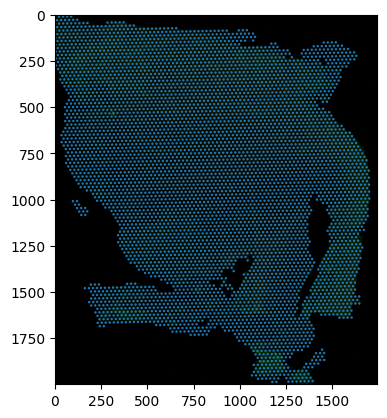

In [19]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
im2 = im.transpose(1,2,0).astype(np.uint8)
ax.imshow(im2, resample=None)
ax.add_collection(spot_patches)

plt.show()